# Processing and narrating a video with GPT's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video
import base64
import time
import openai
import os
import requests

## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [2]:
video = cv2.VideoCapture("data/bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

618 frames read.


Display frames to make sure we've read them in correctly:


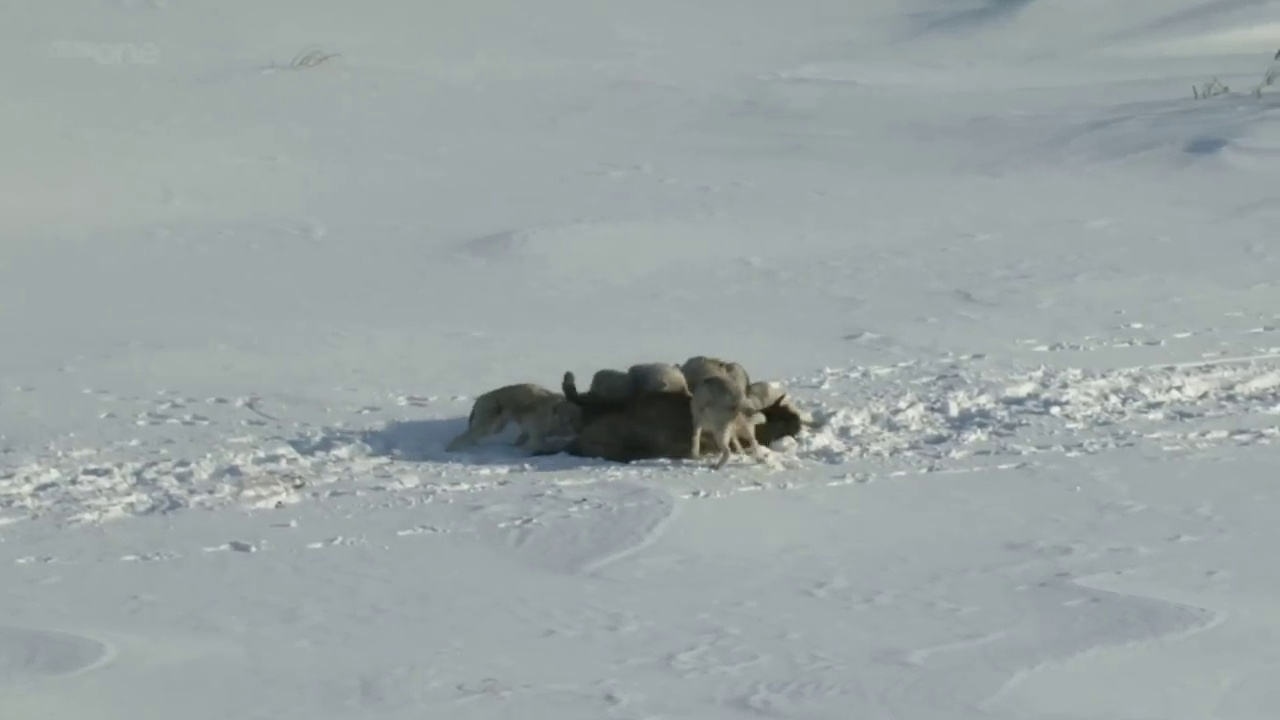

In [3]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [20]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::10]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": os.environ["OPENAI_API_KEY"],
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 200,
}

result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)

Title: Survival Instincts: The Epic Standoff between Bison and Wolves in the Frigid Wild

Description: 
Witness the raw and riveting drama unfold on the snowy plains, where the formidable bison faces off against a determined pack of wolves. Set against a dazzling winter backdrop, this video captures the harrowing and breathtaking interaction between predator and prey. With survival at stake, each move is a dance of life and death in nature's great theater. Watch as these majestic creatures engage in a timeless struggle, showcasing the power, resilience, and indomitable spirit that define the wild. Join us for an unforgettable journey into the heart of nature's resilience – the ultimate testament to the cycle of life in the animal kingdom. #Wildlife #Nature #Survival #BisonVsWolves


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [22]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::10]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": os.environ["OPENAI_API_KEY"],
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 500,
}

result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)

In the vast, white expanse of the winter landscape, a drama unfolds that is as timeless as it is raw. Here, in the cradle of nature's harshest trials, a pack of grey wolves has singled out a bison from the herd—a desperate struggle for life and sustenance is about to begin.

In a carefully orchestrated assault, the pack encircles their quarry, each wolf keenly aware of its role. Muscles tense and breaths visible in the frigid air, they inch closer, probing for a weakness. The bison, a formidable giant, stands its ground, backed by the survival instincts honed over millennia. Its hulking form casts a solitary shadow against the snow's blinding canvas.

The dance of predator and prey plays out as a symphony of survival—each movement, each feint, holds the weight of life itself. The wolves take turns attacking, conserving strength while wearing down their target. The herd, once the bison's allies, scatter into the distance, a stark reminder that in these wild territories, the law of survi

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [3]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)